In [1]:
# Importing pandas library
import pandas as pd
# Creating class to fetch data from given csv files and to make dataframes
class FetchData:
    def __init__(self):
        pass
    
    #Load Data
    def load_dataset(self):
        bks = pd.read_csv('Books.csv', sep=';', encoding='unicode_escape', on_bad_lines='skip', low_memory=False)
        usr = pd.read_csv('Users.csv', sep=';', encoding='unicode_escape', on_bad_lines='skip', low_memory=False)
        rts = pd.read_csv('Book-Ratings.csv', sep=';', encoding='unicode_escape', on_bad_lines='skip', low_memory=False)
        return bks, usr, rts

In [2]:
# Creating class to find recommendations based on user choice
class Recommendation:
    def __init__(self):
        pass
# Function to create similarities between books and recommend books based on given ISBN
    def get_booksimilarity(self, books, users, ratings, var, methd):
        from sklearn.metrics.pairwise import cosine_similarity
        from sklearn.metrics.pairwise import manhattan_distances
        from sklearn.metrics.pairwise import euclidean_distances
        from scipy.spatial import minkowski_distance
        from sklearn.feature_extraction.text import CountVectorizer
# Counting the ratings done by a particular user to filter our dataframe    
        x = ratings['User-ID'].value_counts() > 14
        y = x[x].index
# Ignoring entries of users who haven't done atleast 14 ratings
        ratings = ratings[ratings['User-ID'].isin(y)]

# Merging ratings dataframe and books dataframe based on common ISBN
        new_df = pd.merge(ratings, books, on='ISBN')
# Dropping unwanted columns from our dataframe
        new_df = new_df.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1)

# Creating a new dataframe and checking the number of ratings done by users for all the books
        rating_count = new_df.groupby('Book-Title')['Book-Rating'].count().reset_index()
        rating_count.rename(columns= {'Book-Rating':'Rating Count'}, inplace=True)
        books_new = new_df.merge(rating_count, on='Book-Title')
# Ignoring entries of books if they haven't received atleast 25 ratings
        books_new = books_new[books_new['Rating Count'] >= 25]

# Merging rows based on ISBN, creating a column with average rating for each books
        booksnew = (books_new.groupby(by = ['ISBN'])['Book-Rating'].mean().reset_index()
                    .rename(columns = {'Book-Rating': 'Avg-Rating'})[['ISBN', 'Avg-Rating']])

# Merging books dataframe with our new dataframe and dropping unwanted columns
        final_data = pd.merge(books, booksnew, on='ISBN')
        final_data = final_data.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1)

# Creating a new column by combining book title, book author, year of publication, and average rating of each books to vectorize and analyze
        final_data = final_data.drop_duplicates(subset='Book-Title', keep='first', inplace=False, ignore_index=True)
        final_data = final_data.assign(CombinedData = final_data['Book-Title'].astype(str) + ' ' + 
                                       final_data['Book-Author'].astype(str) + ' ' + 
                                       final_data['Year-Of-Publication'].astype(str) + ' ' + 
                                       final_data.Publisher.astype(str) + ' ' + 
                                       final_data['Avg-Rating'].astype(str))

# Vectorizing the combined data column of our final dataframe and creating a matrix using countvectorizer
        booksmatrix = CountVectorizer().fit_transform(final_data['CombinedData'])

# Checking user preference to find similarity
        if methd=='cosine':
            cossim = cosine_similarity(booksmatrix)
        elif methd=='manhattan':
            cossim = manhattan_distances(booksmatrix)
        elif methd=='euclidean':
            cossim = euclidean_distances(booksmatrix)
        else:
            print('Unkown Method')

        book_id = final_data.index[final_data["ISBN"] == var]

# Finding distances from the output of inbuilt function used
        scores = list(enumerate(cossim[book_id[0]]))

#Sort the list of similar books in descending order
        sorted_scores = sorted(scores, key = lambda x:x[1], reverse=True)
#Eliminate first score, because it is the value of our input
        sorted_scores = sorted_scores[1:]

# Printing output
        k = 0
        for item in sorted_scores:
            location = item[0]
            if k==0:
                print('The 5 most similar books to ', final_data['Book-Title'][location], 'are:\n')
            else:
                print(k,' ', final_data['Book-Title'][location])
            if k >= 5:
                break
            k = k+1

# Function to find similarity between users and to output similar users
    def get_usersimilarity(self, books, users, ratings, var, option, methd):
        
# Importing scipi and sklearn libraries
        from scipy.sparse import csr_matrix
        from sklearn.neighbors import NearestNeighbors
    
# Merging ratings and users dataframes based on user ids
        rating_n_user = pd.merge(ratings, users, on='User-ID')
        rating_n_user = rating_n_user.dropna(axis = 0, subset = ['User-ID'])
        rating_n_user = rating_n_user.drop(['Age'], axis = 1)

# Checking  book rating count and ignoring books that are not even got 350 ratings
        urating_count = rating_n_user.groupby('User-ID')['Book-Rating'].count().reset_index()
        urating_count.rename(columns={'Book-Rating':'Rating Count'}, inplace=True)
        ufinal_rating = rating_n_user.merge(urating_count, left_on='User-ID', right_on='User-ID', how = 'left')
        ufinal_rating = ufinal_rating[ufinal_rating['Rating Count'] >= 350]

# Creating a pivot table where columns are ISBN of books, indices are UserIDs and values are ratings of corresponding books
        user_pivot = ufinal_rating.pivot_table(columns='ISBN', index='User-ID', values='Book-Rating')
# Filling empty value of pivot table with zero
        user_pivot.fillna(0, inplace=True)

# Creating a sparse matrix from the pivot table created using csr_matrix method
        user_sparse = csr_matrix(user_pivot)

# Using KNN to fit model and inputting the method chosen by user
        model = NearestNeighbors(metric=methd, algorithm='brute')
        model.fit(user_sparse)

# Taking distance values with neighbors and recommendations based on distance 
        distance, recommendation = model.kneighbors(user_pivot.loc[var, :].values.reshape(1,-1), n_neighbors = 6)
# If user wants to get similar users based on a given User ID
        if option==2:
            i=0
#         Printing output of similar users based on given UserID
            for i in range(len(recommendation[0])):
                if i==0:
                    print('Users similar to the given UserID:', user_pivot.index[recommendation[0][i]], 'are:\n')
                    print('   User ID\tDistance')
                else:
                    print(i,' ', user_pivot.index[recommendation[0][i]],'\t',round(distance[0][i],2))
                    
# If user wants to get book recommendations based on a given User ID
        elif option==3:
#         Creating an empty list to store index values of recommendations
            buk_choice = []
            i=1
            for i in range(len(recommendation[0])):
                buk_choice.append(user_pivot.index[recommendation[0][i]])
#         Returns final dataframe and the index values list back to the recommendation function
            return ufinal_rating, buk_choice

# If there is an invalid choice function will return zero
        else:
            return(0)

    def get_recommendation(self, b, u, r, v, o, m):
        from sklearn.metrics.pairwise import cosine_similarity
        from sklearn.feature_extraction.text import CountVectorizer
# If user wants to find similar books based on a given ISBN
        if o==1:
            self.get_booksimilarity(b, u, r, v, m)
# If user wants to find similar users based on a given User ID
        elif o==2:
            self.get_usersimilarity(b, u, r, v, o, m)
# If user wants to get book recommendations based on a given User ID
        elif o==3:
#         fetching manipulated dataframe and book choices from get_usersimilarity function
            ufin_dat, book_choices = self.get_usersimilarity(b, u, r, v, o, m)

# Creating an empty dataframe to store User IDs based on index values stored in list from the manipulated dataframe
            new_data1 = pd.DataFrame(columns = ['User-ID', 'ISBN', 'Book-Rating', 'Location', 'Rating Count'])
            for ids in book_choices:
                new_data = ufin_dat[ufin_dat['User-ID'] == ids]
                new_data1 = new_data1.append(new_data)

# Removing unwanted columns from the new dataframe
            new_data1 = new_data1.drop(['Location', 'Rating Count'], axis=1)

# Splitting the dataframe into two dataframes with one containing data of user given user and other containing data of similar users
# 'check_data' dataframe contains data of user given User ID
# 'new_data1' dataframe contains data of all other similar User IDs found using KNN
            check_data = new_data1.loc[(new_data1['User-ID']==book_choices[0])]
            new_data1 = new_data1.loc[(new_data1['User-ID']!=book_choices[0])]

# Removing books of user given User ID from the list of books of similar User IDs
            new_data1['Condition'] = new_data1['ISBN'].isin(check_data['ISBN'])
            new_data1 = new_data1.loc[(new_data1['Condition']==False)]
            new_data1 = new_data1.drop(['Condition'], axis=1)
# Sorting the final dataframe in descending order based on book ratings
            new_data1 = new_data1.sort_values(by=['Book-Rating'], ascending=False)

# Creating a list of first few ISBNs from the sorted dataframe
            isbn_search = new_data1['ISBN'].head(35).tolist()

# Getting titles of books from the list, retrieving book titles and printing the output
            print('Book recommendations based on User ID',v, 'are:')
            isbns = b['ISBN'].tolist()
            c = 0
            counter = 0
            for items in isbn_search:    
                for c in range(len(isbns)):
                    if isbns[c] == items:
                        counter = counter+1
                        print(counter,' ', b['Book-Title'][c])
                    if counter>4:
                        break

        else:
            print('Empty')

In [3]:
#****************************_____MAIN FUNCTION (APP)_____**************************************


class App:
    def __init__(self):
        pass
# Funciton to get user's choice of similarity function
    def sim_choice(self):
        
        smchoice = int(input('Select which method to use from given options:\n' +
                        '1. Type 1 to use Cosine similarity\n' +
                        '2. Type 2 to use Manhattan similarity\n' +
                        '3. Type 3 to use Eucledian similarity\n'))
        if smchoice == 1:
            method = 'cosine'
            print('Calculating.....')
        elif smchoice == 2:
            method = 'manhattan'
            print('Calculating.....')
        elif smchoice == 3:
            print('Calculating.....')
            method = 'euclidean'
        else:
            print('Enter a valid option\n')
        return method
# Returns user's choice of similarity method
    
    def run(self):

# Creating objects of class to fetch data, check similarity and suggest recommendations
        f = FetchData()
        r = Recommendation()
# Creating an infinite loop to run the application till the user exits the application
        while True:
# Asking user to pick an option
            choice = int(input('Please select one from given options\n' +
                           '1. Type 1 to find similar books\n' +
                           '2. Type 2 to find similar users\n' +
                           '3. Type 3 to find book recommendations for a given user\n' +
                           '0. Type 0 to exit application\n\n'))
# Option to get similar books based on given ISBN
            if choice == 1:
                isbn = input('Enter ISBN to get similar books: ')
                mthd = self.sim_choice()
                book, user, rating = f.load_dataset()
                r.get_recommendation(book, user, rating, isbn, choice, mthd)
                continue

# Option to get similar User IDs based on a given User ID
            elif choice == 2:
                userid = int(input('Enter User ID to get similar users: '))
                mthd = self.sim_choice()
                book, user, rating = f.load_dataset()
                r.get_recommendation(book, user, rating, userid, choice, mthd)
                continue

# Option to get book recommendations based on a given User ID
            elif choice == 3:
                buserid = int(input('Enter User ID to find book recommendations: '))
                mthd = self.sim_choice()
                book, user, rating = f.load_dataset()
                r.get_recommendation(book, user, rating, buserid, choice, mthd)
                continue

# Option to exit the application
            elif choice == 0:
                break

# If user enters an invalid option
            else:
                print("Please enter a valid option")     
                continue        

# Main Function

def main():
    app = App()
    app.run()
            
main()

Please select one from given options
1. Type 1 to find similar books
2. Type 2 to find similar users
3. Type 3 to find book recommendations for a given user
0. Type 0 to exit application

0


In [11]:
# Create a subclass from the parent class Similarity
class knn_Similarity(Similarity):
    def __init__(self):
# Run the constructor of parent class
        Similarity.__init__(self)
# Functions to calculate distances using scikit-learn library functions        
    def sq_euclid(self, vector, pivot, id, n=6):
        model = NearestNeighbors(metric='euclidean', algorithm='brute')
        model.fit(vector)
        dist, index = model.kneighbors(pivot.loc[id, :].values.reshape(1, -1), n_neighbors=n)
        return dist, index
    
    def cosine(self, vector, pivot, id, n=6):
        model = NearestNeighbors(metric='cosine', algorithm='brute')
        model.fit(vector)
        dist, index = model.kneighbors(pivot.loc[id, :].values.reshape(1, -1), n_neighbors=n)
        return dist, index
    
    def manhattan(self, vector, pivot, id, n=6):
        model = NearestNeighbors(metric='manhattan', algorithm='brute')
        model.fit(vector)
        dist, index = model.kneighbors(pivot.loc[id, :].values.reshape(1, -1), n_neighbors=n)
        return dist, index
    
    def minkowski_dist(self, vector, pivot, id, n=6):
        model = NearestNeighbors(metric='minkowski', algorithm='brute')
        model.fit(vector)
        dist, index = model.kneighbors(pivot.loc[id, :].values.reshape(1, -1), n_neighbors=n)
        return dist, index

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error as mae
from scipy.sparse import csr_matrix

# Creating class to define functions to test the accuracy of different similarity matrices
class AccuracyTest:
    def __init__(self):
        pass
# Function to calculate similarity matrices and to plot the graph of number of neighbors v/s mean absolute error
    def CalculateNplot(self):
        print('Calculating.....')
# Creating object and fetching data from csv files, creating dataframes
        f = FetchData()
        book, user, rating = f.load_dataset()

# Merging dataframes books and ratings based on ISBN
        book_rating = pd.merge(book, rating, on='ISBN')
# Removing unwanted columns
        book_rating = book_rating.drop(['Year-Of-Publication', 'Publisher', 'Book-Author', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1)
        
# Taking the rating count of each book and resetting the index
        rating_count = (book_rating.groupby(by=['Book-Title'])['Book-Rating'].
                        count().reset_index().rename(columns={'Book-Rating': 'RatingCount'})
                        [['Book-Title', 'RatingCount']])
# Merging the rating count columt with the dataframe
        book_rating = book_rating.merge(rating_count, left_on='Book-Title', right_on='Book-Title', how='left')
        
# Taking only books with rating count greater than 50
        book_rating = book_rating.query('RatingCount >= 50')
# Creating pivot table with User Ids as columns, index as ISBNs and values as rating and filling empty values with zero
        book_rating_pivot = book_rating.pivot(index='ISBN', columns='User-ID', values='Book-Rating').fillna(0)
# Creating sparse matrix from pivot table
        book_rating_matrix = csr_matrix(book_rating_pivot.values)

# Creating object of KNN_Similarity class
        knnsim = knn_Similarity()
        
# Creating empty list to store mean absolute error values calculated by different similarity matrix functions
        cos_vec = []
        euc_vec = []
        min_vec = []
        man_vec = []
        
# Calculating mean absolute error values with different number of samples and storing the results in corresponding lists
        for x in range(6, 151, 5):
            dist, index = knnsim.cosine(book_rating_matrix, book_rating_pivot, '0439139597', x)
            x = dist.flatten()[1:]
            y = np.full((1, len(x)), np.mean(x)).flatten()
            abs_error = mae(x, y, multioutput='raw_values')
            cos_vec.append(abs_error)
            
        for x in range(6, 151, 5):
            dist, index = knnsim.sq_euclid(book_rating_matrix, book_rating_pivot, '0439139597', x)
            x = dist.flatten()[1:]
            y = np.full((1, len(x)), np.mean(x)).flatten()
            abs_error = mae(x, y, multioutput='raw_values')
            euc_vec.append(abs_error)
            
        for x in range(6, 151, 5):
            dist, index = knnsim.minkowski_dist(book_rating_matrix, book_rating_pivot, '0439139597', x)
            x = dist.flatten()[1:]
            y = np.full((1, len(x)), np.mean(x)).flatten()
            abs_error = mae(x, y, multioutput='raw_values')
            min_vec.append(abs_error)
            
        for x in range(6, 151, 5):
            dist, index = knnsim.manhattan(book_rating_matrix, book_rating_pivot, '0439139597', x)
            x = dist.flatten()[1:]
            y = np.full((1, len(x)), np.mean(x)).flatten()
            abs_error = mae(x, y, multioutput='raw_values')
            man_vec.append(abs_error)

# Plotting Mean Absolute Error v/s Number of samples
        plt.plot(cos_vec, color = 'r')
#         plt.title('Cosine')
        plt.xlabel('Number of Samples')
        plt.ylabel('Mean Absolute Error')
        
        plt.plot(euc_vec, color = 'g')
#         plt.title('Eucledian')
        plt.xlabel('Number of Samples')
        plt.ylabel('Mean Absolute Error')
        
        plt.plot(min_vec, color = 'b')
#         plt.title('Minkowski')
        plt.xlabel('Number of Samples')
        plt.ylabel('Mean Absolute Error')
        
        plt.plot(man_vec, color = 'y')
        plt.ylim(0, 25)
        plt.title('Similarity matrices Accuracy Measure')
        plt.xlabel('Number of Samples')
        plt.ylabel('Mean Absolute Error')
        plt.show()
        print('Red\t:\tCosine\nGreen\t:\tEucledian\nBlue\t:\tMinkowski\nYellow\t:\tManhattan\n')

Calculating.....


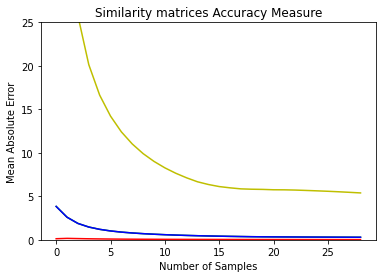

Red	:	Cosine
Green	:	Eucledian
Blue	:	Minkowski
Yellow	:	Manhattan



In [13]:
# Main function to create object to test accuracy of different similarity functions and to run the program
def main():
    t = AccuracyTest()
    t.CalculateNplot()
    
main()

In [ ]:
0439139597